# NIH Chest X-ray Dataset

In [4]:
import os
import cv2
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from itertools import chain
from glob import iglob, glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


%matplotlib inline

In [5]:
PATH = os.path.abspath(os.path.join('..', 'nih_sample/'))
SOURCE_IMAGES = os.path.join(PATH, "images")
images = glob(os.path.join(SOURCE_IMAGES, "*.png"))

In [6]:
images[0:10]


['/Users/Maen/code/nih_sample/images/00018805_001.png',
 '/Users/Maen/code/nih_sample/images/00011723_001.png',
 '/Users/Maen/code/nih_sample/images/00025380_000.png',
 '/Users/Maen/code/nih_sample/images/00008211_000.png',
 '/Users/Maen/code/nih_sample/images/00003459_017.png',
 '/Users/Maen/code/nih_sample/images/00027498_000.png',
 '/Users/Maen/code/nih_sample/images/00019486_001.png',
 '/Users/Maen/code/nih_sample/images/00000733_003.png',
 '/Users/Maen/code/nih_sample/images/00026997_001.png',
 '/Users/Maen/code/nih_sample/images/00017710_005.png']

In [7]:
labels = pd.read_csv('../nih_sample/sample_labels.csv')
labels.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168,0.168
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139,0.139
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139,0.139
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143,0.143
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139,0.139


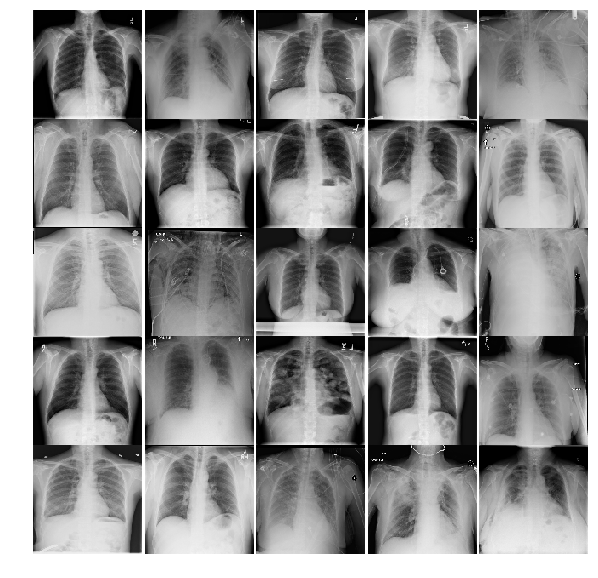

In [8]:
multiple_images = glob('../nih_sample/images/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multiple_images[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

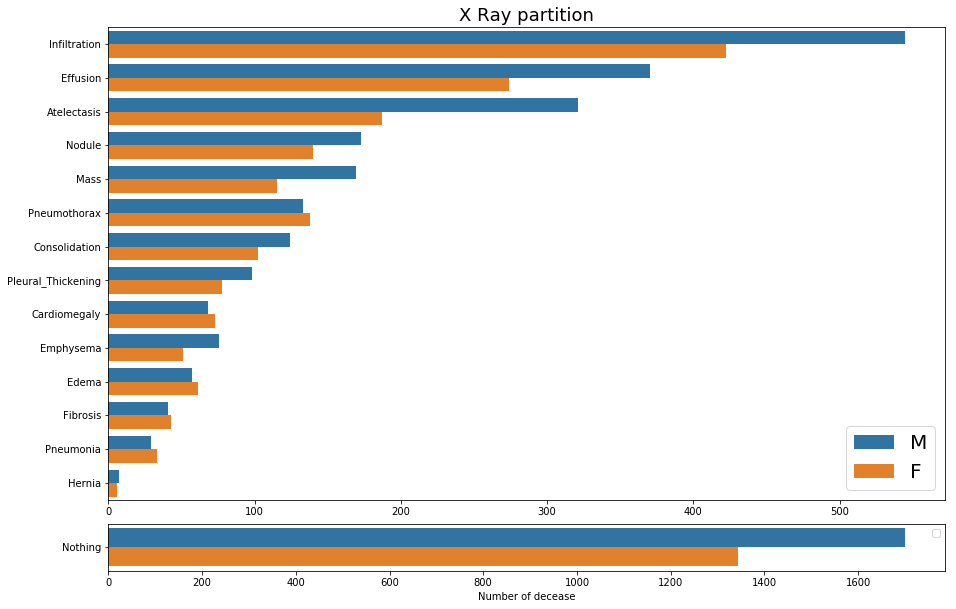

In [9]:
#drop unused columns
labels = labels[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]
#create new columns for each decease
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
for pathology in pathology_list :
    labels[pathology] = labels['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
#remove Y after age
labels['Age']=labels['Patient Age'].apply(lambda x: x[:-1]).astype(int)

plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(labels,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X Ray partition',fontsize=18);

labels['Nothing']=labels['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(labels,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

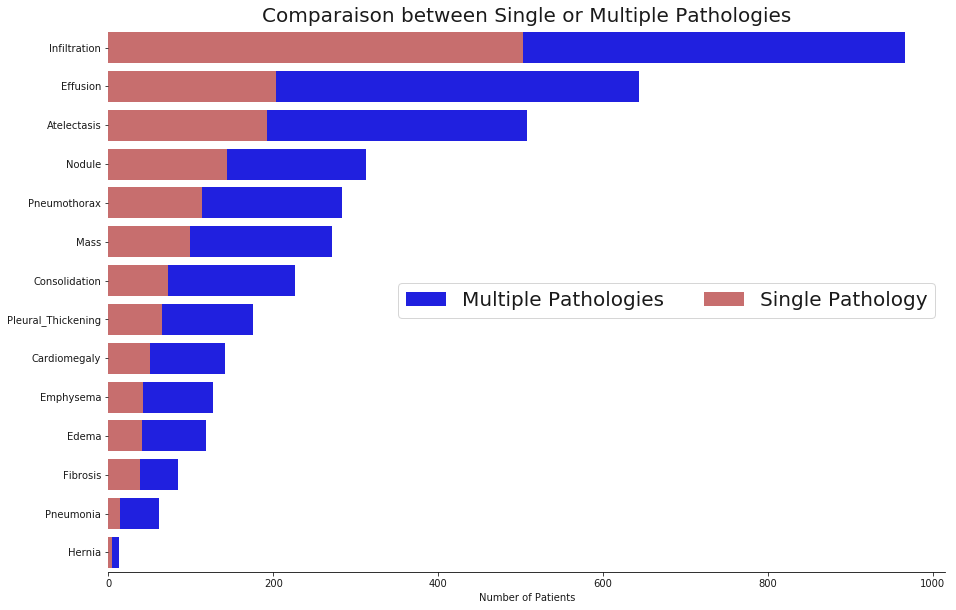

In [10]:
df=labels
data=df.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=data[['|' in index for index in data.index]].copy()
df2=data[['|' not in index for index in data.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values

f, ax = plt.subplots(sharex=True,figsize=(15, 10))
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="r",label="Single Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=20)
ax.set( ylabel="",xlabel="Number of Patients")
ax.set_title("Comparaison between Single or Multiple Pathologies",fontsize=20)      
sns.despine(left=True)